<a href="https://colab.research.google.com/github/Bellajia721/WeatherWise_A2/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [42]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install fetch-my-weather
!pip install hands-on-ai
!pip install requests
!pip install matplotlib
!pip install pyinputplus
!pip install spacy

In [43]:
import os

os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'
os.environ['HANDS_ON_AI_API_KEY'] = input('Enter your API key: ')

Enter your API key: d6ee01b95e1b492baa06b8d295907578.EN_MdtgVL5KhHIQtW024XQJJ


## 📦 Setup and Configuration
Import required packages and setup environment.

In [66]:
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip
import json
import re
import spacy
# ✅ Import after installing (if needed)
from fetch_my_weather import get_weather
from hands_on_ai.chat import get_response
# Add any other setup code here
from ipywidgets import Text, DatePicker, Button, VBox, HTML, Tab
from IPython.display import display
from datetime import datetime, timedelta
from hands_on_ai.chat import get_response

def ai_extend_forecast(weather_data: dict, extra_days: int = 2):
    if not weather_data or "daily" not in weather_data or len(weather_data["daily"]) == 0:
        print("⚠️ No base daily data to extend.")
        return weather_data

    base_days = weather_data["daily"][-3:]
    compact = [
        {
            "date": d.get("date"),
            "max_temp": d.get("maxtempC"),
            "min_temp": d.get("mintempC"),
            "average_temp": d.get("avgtempC"),
            "total_precip": d.get("totalprecipMM"),
        }
        for d in base_days
    ]

    prompt = f"""
    You are a cautious weather assistant.
    Based on the last real 3 daily records below:
    {compact}
    Estimate the next {extra_days} days' weather with realistic smooth trends.
    Return ONLY JSON list with keys: date, max_temp, min_temp, average_temp, total_precip.
    """

    raw = get_response(prompt)
    print("AI raw output:", raw)

    try:
        estimates = json.loads(raw)
    except:
        print(" Model output not JSON — skipping extension.")
        return weather_data

    last_date = datetime.strptime(base_days[-1]["date"], "%Y-%m-%d").date()
    for i, e in enumerate(estimates):
        e["date"] = (last_date + timedelta(days=i + 1)).isoformat()
        e["ai_estimated"] = True
        weather_data["daily"].append(e)

    return weather_data


## 🌤️ Weather Data Functions

In [45]:
# Define get_weather_data() function here
def get_weather_data(location, forecast_days=5):
    """
    Retrieve weather data for a specified location.

    Args:
        location (str): City or location name
        forecast_days (int): Number of days to forecast (1-5)

    Returns:
        dict: Weather data including current conditions and forecast
    """
    try:
      raw = get_weather(location = location, format="raw_json", use_mock = False)
      if isinstance(raw, str) and raw.startswith("Error:"):
        print(f"Weather API returned an error response: {raw}")
        return None
    except Exception as e:
      print(f"An error occurred: {e}")
      return None

    current_weather = (raw.get("current_condition") or [{}])[0]
    desc = None
    if current_weather.get("weatherDesc"):
      desc = (current_weather["weatherDesc"][0] or {}).get("value")
    forecast_weather = (raw.get("weather") or [])[:forecast_days]

    return {
        "location": location,
        "current_weather": {
            "temperature": current_weather.get("temp_C"),
            "windspeed": current_weather.get("windspeedKmph"),
            "humidity": current_weather.get("humidity"),
            "precipitation": current_weather.get("precipMM"),
            "descripption": desc
        },
        "daily":[
            {
                 "date": d.get("date"),
                 "average_temp": d.get("avgtempC"),
                 "windspeed": d.get("MaxwindKmph"),
                 "humidity": d.get("avghumidity"),
                 "total_precip": d.get("totalprecipMM"),
                 "max_temp": d.get("maxtempC"),
                 "min_temp": d.get("mintempC"),
        }
        for d in forecast_weather
      ]
    }

## 📊 Visualisation Functions

In [46]:
# Define create_temperature_visualisation() and create_precipitation_visualisation() here
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of temperature data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
    if not "daily" in weather_data:
      print("No temperature data available")
      return None

    days = weather_data["daily"]
    dates = [d["date"] for d in days]
    avg_temp = [float(d["average_temp"]) for d in days]
    max_temp = [float(d["max_temp"]) for d in days]
    min_temp = [float(d["min_temp"]) for d in days]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(dates, avg_temp, label ='Average Temperature(°C)', color = 'green', marker ='o')
    ax.plot(dates, max_temp, label ='Maximum Temperature(°C)', color = 'red', marker ='^')
    ax.plot(dates, min_temp, label ='Minimum Temperature(°C)', color = 'blue', marker ='v')
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title('Temperature Trends')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=30)

    if output_type == 'figure':
      return fig
    else:
      plt.show()


In [47]:
def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of precipitation data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
    if not "daily" in weather_data:
      print("No precipitation data available")
      return None
    days = weather_data["daily"]
    dates = [d["date"] for d in days]
    total_precip = [float(d.get("total_precip") or 0) for d in days]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(dates, total_precip, label='Total Precipitation (mm)', color='darkblue', marker='s')
    ax.set_xlabel('Date')
    ax.set_ylabel('Precipitation (mm)')
    ax.set_title('Precipitation Trends')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=30)

    if output_type == 'figure':
      return fig
    else:
      plt.show()

In [48]:
def create_windspeed_visualisation(weather_data, output_type='display'):
  if not "daily" in weather_data:
    print("No windspeed data available")
    return None
  days = weather_data["daily"]
  dates = [d["date"] for d in days]
  windspeed = [float(d.get("windspeed") or 0) for d in days]

  fig, ax = plt.subplots(figsize=(10, 6))
  ax.plot(dates, windspeed, label='Wind Speed (km/h)', color='purple', marker='D')
  ax.set_xlabel('Date')
  ax.set_ylabel('Wind Speed (km/h)')
  ax.set_title('Wind Speed Trends')
  ax.legend()
  ax.grid(True)
  plt.xticks(rotation=30)

  if output_type == 'figure':
    return fig
  else:
    plt.show()

In [49]:
def create_humidity_visualisation(weather_data, output_type='display'):
  if not "daily" in weather_data:
    print("No humidity data available")
    return None
  days = weather_data["daily"]
  dates = [d["date"] for d in days]
  humidity = [float(d.get("humidity") or 0) for d in days]
  fig, ax = plt.subplots(figsize=(10, 6))
  ax.plot(dates, humidity, label='Humidity (%)', color='orange', marker='h')
  ax.set_xlabel('Date')
  ax.set_ylabel('Humidity (%)')
  ax.set_title('Humidity Trends')
  ax.legend()
  ax.grid(True)
  plt.xticks(rotation=30)

  if output_type == 'figure':
    return fig
  else:
    plt.show()

## 🤖 Natural Language Processing

In [59]:
# Define parse_weather_question() and generate_weather_response() here
def parse_weather_question(question):
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Extracted information including location, time period, and weather attribute
    """
    weekdays = {
        "monday": 1, "mon": 1,
        "tuesday": 2, "tue": 2,
        "wednesday": 3, "wed": 3,
        "thursday": 4, "thu": 4,
        "friday": 5, "fri": 5,
        "saturday": 6, "sat": 6,
        "sunday": 7, "sun": 7
    }
    weather_keywords = {
        "temperature": {"temp", "temperature", "hot", "cold", "warm", "cool"},
        "precipitation": {"precipitation", "rain", "snow", "precip"},
        "wind": {"wind", "windy"},
        "humidity": {"humidity", "humid", "dry", "wet"},
        "summary": {"weather", "forecast", "summary"},
    }
    def find_weather_keywords(question: str):
      text = question.lower()
      for keyword, values in weather_keywords.items():
        for value in values:
          if value in text:
            return keyword
      return "summary"

    text = question.lower()

    when = None
    if "today" in text:
      when = "today"
    elif "tomorrow" in text:
      when = "tomorrow"
    else:
      for day, number in weekdays.items():
        if day in text:
          when = number
          break

    model = spacy.load("en_core_web_sm")
    def find_location(text):
      doc = model(text)
      location = None
      for ent in doc.ents:
        if ent.label_ == "GPE":
          location = ent.text
          break
      return location

    location = find_location(question)
    attribute = find_weather_keywords(question)

    return {
        "City": location,
        "Date": when,
        "attribute": attribute
    }




## 🧭 User Interface

In [ ]:
# Define menu functions using pyinputplus or ipywidgets here
city_input = Text(description = 'City:', placeholder = 'e.g. Perth')
date_input = DatePicker(description = 'Date:')
submit_button = Button(description='Get Weather', button_style='success')
status_box = HTML(value='')
output_box = HTML(value='')


def on_submit_button_click(b):
  if True:
    city = city_input.value
    date = date_input.value.strftime('%m-%d-%y')
    print(f'City: {city}')
    print(f'Date: {date}')


  if not city_input:
    status_box.value = "Please enter a city."
  if not date_input:
    status_box.value = "Please pick a date."

  try:
    city = city_input.value
    data = get_weather_data(city, forecast_days = 5)
    ai_extend_forecast(data)

    def format_daily_weather_lines(d):
      date = d.get("date_input")
      max_temp = d.get("max_temp")
      min_temp = d.get("min_temp")
      average_temp = d.get("average_temp")
      total_precip = d.get("total_precip")
      windspeed = d.get("windspeed")
      humidity = d.get("humidity")
      return f"{date}: Max: {max_temp}°C, Min: {min_temp}°C, Avg: {average_temp}°C, Precip: {total_precip}mm, Wind: {windspeed}km/h, Humidity: {humidity}%"

    output_box.value = format_daily_weather_lines(data)
    create_temperature_visualisation(data)
    create_precipitation_visualisation(data)
    create_windspeed_visualisation(data)
    create_humidity_visualisation(data)
  except Exception as e:
    status_box.value = f"Error: {e}"

nlp_input = Text(
    description='Ask:',
    placeholder='e.g. Will it rain in Perth tomorrow?'
)
parse_btn = Button(description='Auto-fill', button_style='info')

def when_to_date(when):
  if when is None:
    return None
  today = datetime.today().date()
  if isinstance(when, str):
    time = when.lower().strip()
    if time == "today":
      return today
    if time == "tomorrow":
      return today + timedelta(days=1)
    return when
  if isinstance(when, int) and 1 <= when <= 7:
    today_weekday = today.weekday()
    when_weekday = (today_weekday + when) % 7
    if when_weekday < today_weekday:
      when_weekday += 7
    return today + timedelta(days=when_weekday - today_weekday)
  return None

def on_parse_btn_click(b):
  question = nlp_input.value
  if not question:
        status_box.value = "Please enter a question."
        return
  parsed = parse_weather_question(question)
  city = parsed.get("City")
  when = when_to_date(parsed.get("Date"))
  attribute = parsed.get("attribute")
  if city:
        city_input.value = city
  if when:
        date_input.value = when

parse_btn.on_click(on_parse_btn_click)

manual_box = VBox([city_input, date_input, submit_button])
nlp_box = VBox([nlp_input, parse_btn])

tabs = Tab(children=[manual_box, nlp_box])
tabs.set_title(0, 'Manual')
tabs.set_title(1, 'Natural language')

display(tabs)

submit_button.on_click(on_submit_button_click)

display(VBox([status_box, output_box]))


## 🧩 Main Application Logic

In [84]:
from ast import Attribute
# Tie everything together here
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
    if not weather_data:
        return "Sorry, I couldn't get any weather data."

    city = weather_data.get("location") or parsed_question.get("City") or "the location"
    attribute = (parsed_question.get("attribute") or "summary").lower()
    when = parsed_question.get("Date")

    daily = weather_data.get("daily", [])
    if not daily:
        return f"I got weather for {city}, but there are no daily entries to summarise."
    target_date = when_to_date(when)
    daily = weather_data["daily"]

    chosen = None
    chosen_dt = None

    if target_date is not None:
        iso = target_date.isoformat()
        for d in daily:
            if (d.get("date") or "").startswith(iso):
                chosen = d
                chosen_dt = target_date
                break

    if chosen is None and daily:
        chosen = daily[0]
        try:
            chosen_dt = datetime.strptime(chosen.get("date", ""), "%Y-%m-%d").date()
        except Exception:
            chosen_dt = None

    if chosen_dt:
      date_text = chosen_dt.strftime("%A, %B %d")   # 例如：Monday, October 21
    else:
      date_text = chosen.get("date", "Unknown date")

    average_temp = chosen.get("average_temp")
    max_temp = chosen.get("max_temp")
    min_temp = chosen.get("min_temp")
    total_precipitation = chosen.get("total_precip") or 0
    windspeed = chosen.get("windspeed")
    humidity = chosen.get("humidity")
    is_ai_estimated = chosen.get("ai_estimated")

    if attribute == "temperature":
        sentence = f"In {city} on {date_text}, the average temperature is around {average_temp}°C (high {max_temp}°C / low {min_temp}°C)."
    elif attribute == "precipitation":
        sentence = f"In {city} on {date_text}, total precipitation is approximately {total_precipitation} mm."
    elif attribute == "wind":
        sentence = f"In {city} on {date_text}, wind speed is about {windspeed} km/h."
    elif attribute == "humidity":
        sentence = f"In {city} on {date_text}, humidity is around {humidity}%."
    else:
       sentence = (
            f"In {city} on {date_text}, average {average_temp}°C (high {max_temp}°C / low {min_temp}°C), "
            f"precipitation {total_precipitation} mm, wind {windspeed} km/h, humidity {humidity}%."
        )

    if is_ai_estimated:
        sentence += " (last part estimated by AI)"

    return sentence

## 🧪 Testing and Examples

In [77]:
# Include sample input/output for each function

# Test parse_weather_question()
example_question = "Will it rain in Perth today?"
parsed = parse_weather_question(example_question)
print(parsed)

{'City': 'Perth', 'Date': 'today', 'attribute': 'precipitation'}


In [78]:
# Test get_weather_data()
data = get_weather_data("Perth", forecast_days=3)
print(json.dumps(data, indent=2))

{
  "location": "Perth",
  "current_weather": {
    "temperature": "16",
    "windspeed": "11",
    "humidity": "63",
    "precipitation": "0.2",
    "descripption": "Partly cloudy"
  },
  "daily": [
    {
      "date": "2025-10-19",
      "average_temp": "16",
      "windspeed": null,
      "humidity": null,
      "total_precip": null,
      "max_temp": "19",
      "min_temp": "14"
    },
    {
      "date": "2025-10-20",
      "average_temp": "14",
      "windspeed": null,
      "humidity": null,
      "total_precip": null,
      "max_temp": "17",
      "min_temp": "13"
    },
    {
      "date": "2025-10-21",
      "average_temp": "15",
      "windspeed": null,
      "humidity": null,
      "total_precip": null,
      "max_temp": "18",
      "min_temp": "11"
    }
  ]
}


In [85]:
# Test generate_weather_response()
parsed_question = {
    "City": "Perth",
    "Date": "tomorrow",
    "attribute": "temperature"
}

response = generate_weather_response(parsed_question, data)
print(response)

In Perth on Monday, October 20, the average temperature is around 14°C (high 17°C / low 13°C).


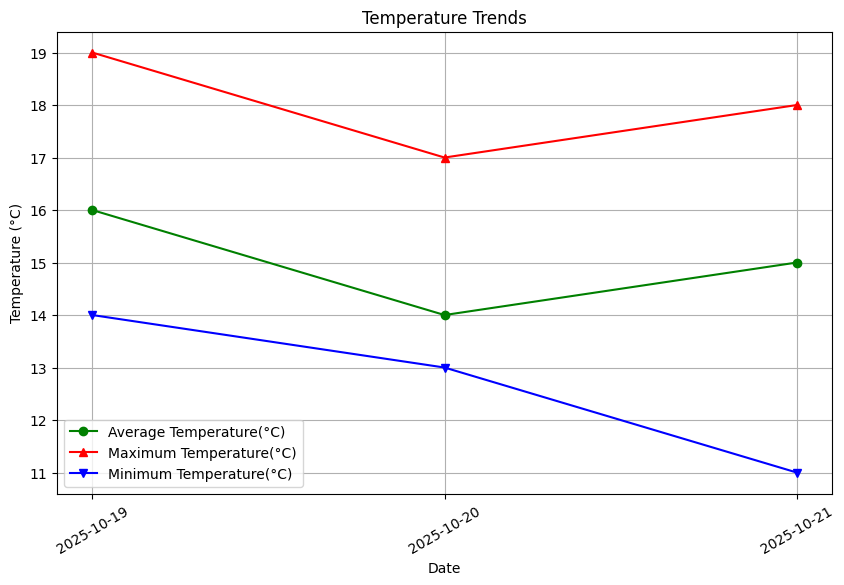

In [87]:
# Test create_temperature_visualisation()
create_temperature_visualisation(data)

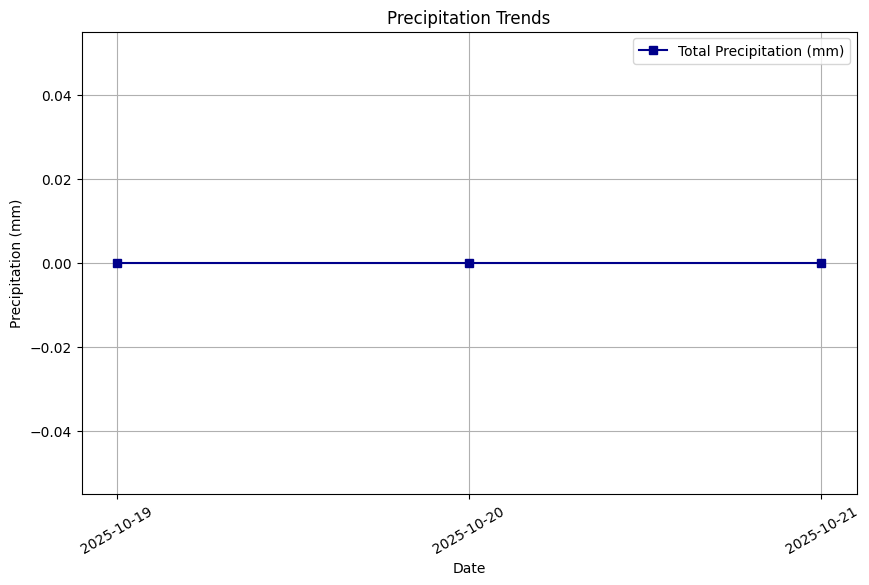

In [88]:
# Test create_precipitation_visualisation()
create_precipitation_visualisation(data)

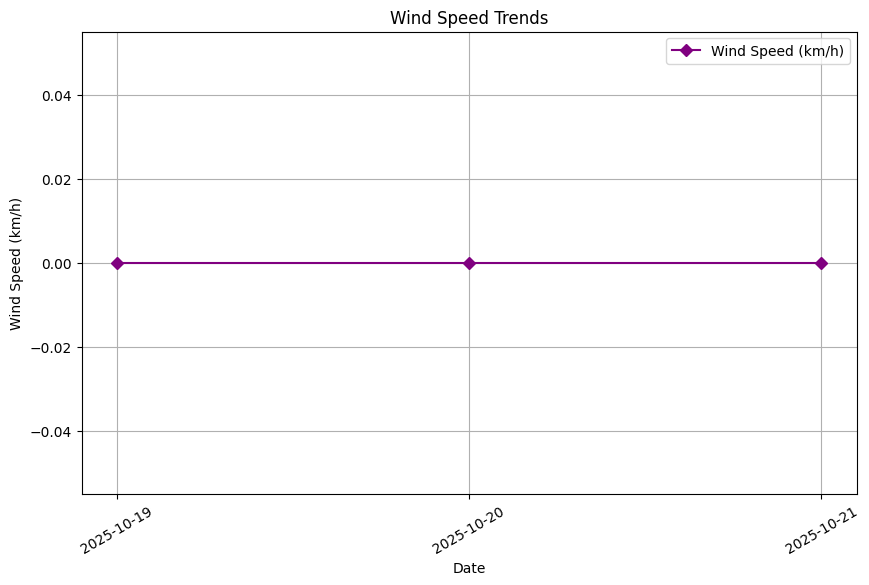

In [89]:
# Test create_windspeed_visualisation()
create_windspeed_visualisation(data)

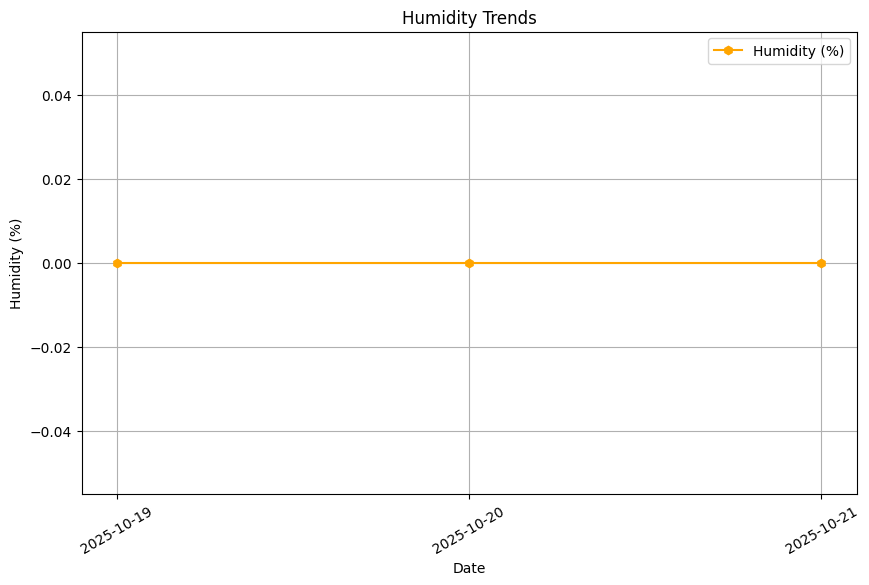

In [90]:
# Test create_humidity_visualisation()
create_humidity_visualisation(data)

In [91]:
# Test ai_extend_forecast()
extended_data = ai_extend_forecast(data)
print(json.dumps(extended_data, indent=2))

[WARNING] Error during request (attempt 1): 405 method not allowed


Hang tight, I'm thinking... trying again!


[WARNING] Error during request (attempt 2): 405 method not allowed


AI raw output: ❌ Error: 405 method not allowed
 Model output not JSON — skipping extension.
{
  "location": "Perth",
  "current_weather": {
    "temperature": "16",
    "windspeed": "11",
    "humidity": "63",
    "precipitation": "0.2",
    "descripption": "Partly cloudy"
  },
  "daily": [
    {
      "date": "2025-10-19",
      "average_temp": "16",
      "windspeed": null,
      "humidity": null,
      "total_precip": null,
      "max_temp": "19",
      "min_temp": "14"
    },
    {
      "date": "2025-10-20",
      "average_temp": "14",
      "windspeed": null,
      "humidity": null,
      "total_precip": null,
      "max_temp": "17",
      "min_temp": "13"
    },
    {
      "date": "2025-10-21",
      "average_temp": "15",
      "windspeed": null,
      "humidity": null,
      "total_precip": null,
      "max_temp": "18",
      "min_temp": "11"
    }
  ]
}


In [92]:
#Full Test

user_input = "What will the temperature be in Perth tomorrow?"
parsed = parse_weather_question(user_input)
result = generate_weather_response(parsed, data)

print("User Question:", user_input)
print("Parsed:", parsed)
print("Response:", result)

User Question: What will the temperature be in Perth tomorrow?
Parsed: {'City': 'Perth', 'Date': 'tomorrow', 'attribute': 'temperature'}
Response: In Perth on Monday, October 20, the average temperature is around 14°C (high 17°C / low 13°C).


## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.